<a href="https://colab.research.google.com/github/krsna-thecoder/CNN---DEEP-LEARNING/blob/main/four_qubits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install pennylane scikit-learn pillow

In [9]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.decomposition import PCA
from tensorflow.keras.datasets import fashion_mnist
from PIL import Image


In [10]:

(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = fashion_mnist.load_data()

# Binary classes: 0 (T-shirt), 1 (Trouser)
train_idx = np.where((y_train_raw == 0) | (y_train_raw == 1))
test_idx  = np.where((y_test_raw == 0) | (y_test_raw == 1))

x_train, y_train = x_train_raw[train_idx], y_train_raw[train_idx]
x_test, y_test   = x_test_raw[test_idx], y_test_raw[test_idx]

# Normalize
x_train = x_train.reshape(len(x_train), -1) / 255.0
x_test  = x_test.reshape(len(x_test), -1) / 255.0

# Label mapping: {0 → +1, 1 → -1}
y_train = np.where(y_train == 0, 1, -1)
y_test  = np.where(y_test == 0, 1, -1)


In [11]:
# ==============================
# 8. PCA (4 QUBITS)
# ==============================
N_QUBITS_4 = 4
pca_4 = PCA(n_components=N_QUBITS_4)

x_train_4 = pca_4.fit_transform(x_train)
x_test_4  = pca_4.transform(x_test)

xmin4, xmax4 = x_train_4.min(), x_train_4.max()
x_train_4 = 2 * (x_train_4 - xmin4) / (xmax4 - xmin4) - 1
x_test_4  = 2 * (x_test_4 - xmin4) / (xmax4 - xmin4) - 1


In [12]:
dev4 = qml.device("default.qubit", wires=N_QUBITS_4)

@qml.qnode(dev4)
def qcnn_4(weights, x):
    for i in range(N_QUBITS_4):
        qml.RY(np.pi * x[i], wires=i)
        qml.RY(weights[i], wires=i)
    for i in range(N_QUBITS_4 - 1):
        qml.CNOT(wires=[i, i + 1])
    return qml.expval(qml.PauliZ(0))


In [13]:
def qcnn_accuracy(weights, X, Y):
    preds = [1 if qcnn_4(weights, x) > 0 else -1 for x in X]
    return np.mean(np.array(preds) == Y)


In [15]:
def loss_4(weights):
    loss = 0
    for i in range(50):
        pred = qcnn_4(weights, x_train_4[i])
        loss += (pred - y_train[i])**2
    return loss / 50

qcnn_acc_history = []

weights_4 = np.random.normal(0, 0.1, N_QUBITS_4, requires_grad=True)
opt = qml.AdamOptimizer(stepsize=0.05)

for epoch in range(40):
    weights_4 = opt.step(loss_4, weights_4)

    acc = qcnn_accuracy(
        weights_4,
        x_test_4[:50],
        y_test[:50]
    )

    qcnn_acc_history.append(acc)

    print(f"Epoch {epoch+1} | QCNN Accuracy: {acc:.3f}")

Epoch 1 | QCNN Accuracy: 0.460
Epoch 2 | QCNN Accuracy: 0.460
Epoch 3 | QCNN Accuracy: 0.560
Epoch 4 | QCNN Accuracy: 0.600
Epoch 5 | QCNN Accuracy: 0.600
Epoch 6 | QCNN Accuracy: 0.620
Epoch 7 | QCNN Accuracy: 0.700
Epoch 8 | QCNN Accuracy: 0.700
Epoch 9 | QCNN Accuracy: 0.720
Epoch 10 | QCNN Accuracy: 0.780
Epoch 11 | QCNN Accuracy: 0.820
Epoch 12 | QCNN Accuracy: 0.840
Epoch 13 | QCNN Accuracy: 0.840
Epoch 14 | QCNN Accuracy: 0.840
Epoch 15 | QCNN Accuracy: 0.840
Epoch 16 | QCNN Accuracy: 0.840
Epoch 17 | QCNN Accuracy: 0.840
Epoch 18 | QCNN Accuracy: 0.820
Epoch 19 | QCNN Accuracy: 0.840
Epoch 20 | QCNN Accuracy: 0.820
Epoch 21 | QCNN Accuracy: 0.820
Epoch 22 | QCNN Accuracy: 0.820
Epoch 23 | QCNN Accuracy: 0.820
Epoch 24 | QCNN Accuracy: 0.800
Epoch 25 | QCNN Accuracy: 0.820
Epoch 26 | QCNN Accuracy: 0.820
Epoch 27 | QCNN Accuracy: 0.820
Epoch 28 | QCNN Accuracy: 0.820
Epoch 29 | QCNN Accuracy: 0.820
Epoch 30 | QCNN Accuracy: 0.820
Epoch 31 | QCNN Accuracy: 0.820
Epoch 32 | QCNN A

In [16]:

def accuracy_4(weights, X, Y):
    preds = [1 if qcnn_4(weights, x) > 0 else -1 for x in X]
    return np.mean(np.array(preds) == Y)

print("4-Qubit Test Accuracy:", accuracy_4(weights_4, x_test_4[:50], y_test[:50]))


4-Qubit Test Accuracy: 0.82


In [17]:

preds = [qcnn_4(weights_4, x) for x in x_test_4[:50]]
print(preds)


[tensor(-0.80198404, requires_grad=True), tensor(-0.99610395, requires_grad=True), tensor(-0.4608263, requires_grad=True), tensor(-0.93022162, requires_grad=True), tensor(0.92519596, requires_grad=True), tensor(-0.98760136, requires_grad=True), tensor(0.92114107, requires_grad=True), tensor(-0.3006903, requires_grad=True), tensor(-0.85126913, requires_grad=True), tensor(-0.73161805, requires_grad=True), tensor(-0.5764901, requires_grad=True), tensor(-0.77611202, requires_grad=True), tensor(-0.99765027, requires_grad=True), tensor(-0.81849706, requires_grad=True), tensor(-0.74733971, requires_grad=True), tensor(-0.99313456, requires_grad=True), tensor(0.98902177, requires_grad=True), tensor(0.99929387, requires_grad=True), tensor(-0.93085932, requires_grad=True), tensor(-0.40590538, requires_grad=True), tensor(-0.84254308, requires_grad=True), tensor(0.93382066, requires_grad=True), tensor(0.72448717, requires_grad=True), tensor(0.56515617, requires_grad=True), tensor(0.92193235, requir

In [18]:
# checking for class wise accuracy
def class_wise_accuracy_4(weights, X, Y):
    results = {}
    for label in [1, -1]:  # 1 = T-shirt, -1 = Trouser
        idx = [i for i in range(len(Y)) if Y[i] == label]
        correct = 0
        for i in idx:
            pred = 1 if qcnn_4(weights, X[i]) > 0 else -1
            if pred == Y[i]:
                correct += 1
        results[label] = correct / len(idx)
    return results

acc = class_wise_accuracy_4(weights_4, x_test_4[:50], y_test[:50])
print("T-shirt accuracy:", acc[1])
print("Trouser accuracy:", acc[-1])


T-shirt accuracy: 0.6818181818181818
Trouser accuracy: 0.9285714285714286


In [19]:
# checking for confusion matrix
def confusion_matrix_4(weights, X, Y):
    TP = TN = FP = FN = 0
    for x, y in zip(X, Y):
        pred = 1 if qcnn_4(weights, x) > 0 else -1
        if y == 1 and pred == 1: TP += 1
        if y == -1 and pred == -1: TN += 1
        if y == -1 and pred == 1: FP += 1
        if y == 1 and pred == -1: FN += 1
    return TP, FP, FN, TN

TP, FP, FN, TN = confusion_matrix_4(weights_4, x_test_4[:50], y_test[:50])
print("Confusion Matrix")
print("TP:", TP, "FP:", FP)
print("FN:", FN, "TN:", TN)


Confusion Matrix
TP: 15 FP: 2
FN: 7 TN: 26


In [21]:
#checking for accuracy vs confidence
def accuracy_with_threshold_4(weights, X, Y, threshold):
    correct = 0
    count = 0
    for x, y in zip(X, Y):
        val = qcnn_4(weights, x)
        if abs(val) >= threshold:  # only confident predictions
            pred = 1 if val > 0 else -1
            correct += (pred == y)
            count += 1
    return correct / count if count > 0 else None

for t in [0.0, 0.3, 0.6]:
    acc = accuracy_with_threshold_4(weights_4, x_test_4[:50], y_test[:50], t)
    print(f"Accuracy for |output| ≥ {t}:", acc)


Accuracy for |output| ≥ 0.0: 0.82
Accuracy for |output| ≥ 0.3: 0.8666666666666667
Accuracy for |output| ≥ 0.6: 0.9459459459459459


In [22]:
#checking for utput distribution
outputs = [float(qcnn_4(weights_4, x)) for x in x_test_4[:50]]

print("Mean output:", np.mean(outputs))
print("Std output :", np.std(outputs))
print("Min, Max  :", min(outputs), max(outputs))


Mean output: -0.2787027867508446
Std output : 0.7354325748139536
Min, Max  : -0.9993016890131136 0.9992938694554537


now greating a hybrid model by using quantum convolution layer+classical neural network for learning

In [23]:
dev_hybrid = qml.device("default.qubit", wires=N_QUBITS_4)

@qml.qnode(dev_hybrid)
def quantum_filter(weights, x):

    for i in range(N_QUBITS_4):
        qml.RY(np.pi * x[i], wires=i)


    for i in range(N_QUBITS_4):
        qml.RY(weights[i], wires=i)

    for i in range(N_QUBITS_4 - 1):
        qml.CNOT(wires=[i, i + 1])


    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS_4)]


In [24]:
#creating a head
def classical_head(params, q_features):
    W1, b1, W2, b2 = params
    h = np.tanh(np.dot(q_features, W1) + b1)
    out = np.dot(h, W2) + b2
    return out[0]


In [25]:
def hybrid_forward(weights_q, weights_c, x):
    q_out = quantum_filter(weights_q, x)
    return classical_head(weights_c, np.array(q_out))


In [26]:
def hybrid_loss(weights_q, weights_c):
    loss = 0
    for i in range(200):
        pred = hybrid_forward(weights_q, weights_c, x_train_4[i])
        loss += (pred - y_train[i])**2
    return loss / 200


In [27]:
weights_q = np.random.normal(0, 0.1, N_QUBITS_4, requires_grad=True)

W1 = np.random.normal(0, 0.2, (N_QUBITS_4, 8), requires_grad=True)
b1 = np.zeros(8, requires_grad=True)
W2 = np.random.normal(0, 0.2, (8, 1), requires_grad=True)
b2 = np.zeros(1, requires_grad=True)

weights_c = [W1, b1, W2, b2]


In [28]:
hybrid_acc_history = []


In [29]:
opt = qml.AdamOptimizer(0.02)

for epoch in range(40):
    weights_q, weights_c = opt.step(
        lambda *args: hybrid_loss(args[0], args[1]),
        weights_q, weights_c
    )

    acc = np.mean([
        np.sign(hybrid_forward(weights_q, weights_c, x_test_4[i])) == y_test[i]
        for i in range(50)
    ])

    hybrid_acc_history.append(acc)

    print(f"Epoch {epoch+1} | Hybrid (1 filter) Accuracy: {acc:.3f}")


Epoch 1 | Hybrid (1 filter) Accuracy: 0.660
Epoch 2 | Hybrid (1 filter) Accuracy: 0.680
Epoch 3 | Hybrid (1 filter) Accuracy: 0.700
Epoch 4 | Hybrid (1 filter) Accuracy: 0.700
Epoch 5 | Hybrid (1 filter) Accuracy: 0.720
Epoch 6 | Hybrid (1 filter) Accuracy: 0.760
Epoch 7 | Hybrid (1 filter) Accuracy: 0.760
Epoch 8 | Hybrid (1 filter) Accuracy: 0.760
Epoch 9 | Hybrid (1 filter) Accuracy: 0.780
Epoch 10 | Hybrid (1 filter) Accuracy: 0.800
Epoch 11 | Hybrid (1 filter) Accuracy: 0.840
Epoch 12 | Hybrid (1 filter) Accuracy: 0.840
Epoch 13 | Hybrid (1 filter) Accuracy: 0.860
Epoch 14 | Hybrid (1 filter) Accuracy: 0.860
Epoch 15 | Hybrid (1 filter) Accuracy: 0.860
Epoch 16 | Hybrid (1 filter) Accuracy: 0.860
Epoch 17 | Hybrid (1 filter) Accuracy: 0.860
Epoch 18 | Hybrid (1 filter) Accuracy: 0.880
Epoch 19 | Hybrid (1 filter) Accuracy: 0.880
Epoch 20 | Hybrid (1 filter) Accuracy: 0.880
Epoch 21 | Hybrid (1 filter) Accuracy: 0.880
Epoch 22 | Hybrid (1 filter) Accuracy: 0.880
Epoch 23 | Hybrid (

In [30]:
#calculating the accuracy for the hybrid model
def hybrid_accuracy(weights_q, weights_c, X, Y):
    preds = []
    for x in X:
        val = hybrid_forward(weights_q, weights_c, x)
        preds.append(1 if val > 0 else -1)
    return np.mean(np.array(preds) == Y)

In [31]:

print("Hybrid Test Accuracy:",
      hybrid_accuracy(weights_q, weights_c, x_test_4[:50], y_test[:50]))

Hybrid Test Accuracy: 0.92


In [32]:
hybrid_preds = [hybrid_forward(weights_q, weights_c, x)
                for x in x_test_4[:50]]

print(hybrid_preds)

[tensor(-0.35622438, requires_grad=True), tensor(-0.24123736, requires_grad=True), tensor(-0.32944384, requires_grad=True), tensor(-0.2964959, requires_grad=True), tensor(0.31661211, requires_grad=True), tensor(-0.26986077, requires_grad=True), tensor(0.05654471, requires_grad=True), tensor(0.09333876, requires_grad=True), tensor(-0.35978375, requires_grad=True), tensor(-0.39348646, requires_grad=True), tensor(0.11826528, requires_grad=True), tensor(-0.33995283, requires_grad=True), tensor(-0.08214398, requires_grad=True), tensor(0.13381075, requires_grad=True), tensor(-0.39331197, requires_grad=True), tensor(-0.01834661, requires_grad=True), tensor(0.27798294, requires_grad=True), tensor(0.21334925, requires_grad=True), tensor(-0.36064488, requires_grad=True), tensor(0.09556172, requires_grad=True), tensor(-0.34800058, requires_grad=True), tensor(0.2231359, requires_grad=True), tensor(-0.01863841, requires_grad=True), tensor(0.35392545, requires_grad=True), tensor(0.27781042, requires

In [33]:
import matplotlib.pyplot as plt


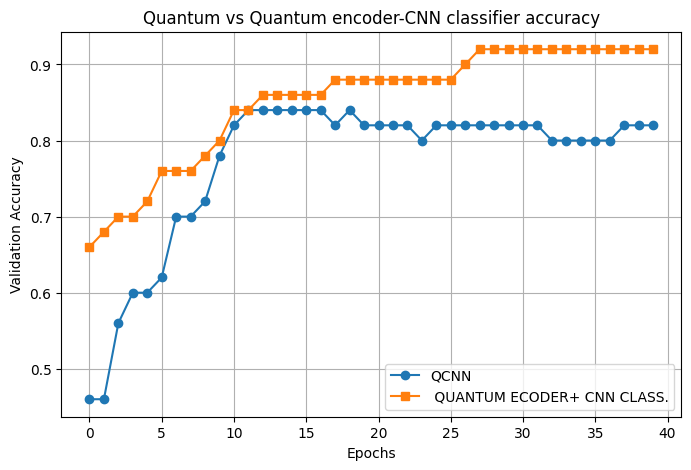

In [50]:
plt.figure(figsize=(8,5))

plt.plot(qcnn_acc_history, label="QCNN", marker='o')
plt.plot(hybrid_acc_history, label=" QUANTUM ECODER+ CNN CLASS.", marker='s')

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Quantum vs Quantum encoder-CNN classifier accuracy")
plt.legend()
plt.grid(True)

plt.show()


In [43]:
def make_quantum_filter():

    dev = qml.device("default.qubit", wires=N_QUBITS_4)

    @qml.qnode(dev)
    def qfilter(weights, x):
        for i in range(N_QUBITS_4):
            qml.RY(np.pi * x[i], wires=i)

        for i in range(N_QUBITS_4):
            qml.RY(weights[i], wires=i)

        for i in range(N_QUBITS_4 - 1):
            qml.CNOT(wires=[i, i + 1])

        return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS_4)]

    return qfilter


In [44]:
N_FILTERS = 3

quantum_filters = [make_quantum_filter() for _ in range(N_FILTERS)]

weights_q_multi = [
    np.random.normal(0, 0.1, N_QUBITS_4, requires_grad=True)
    for _ in range(N_FILTERS)
]


In [45]:
def classical_head_multi(params, q_features):
    W1, b1, W2, b2 = params
    h = np.tanh(np.dot(q_features, W1) + b1)
    out = np.dot(h, W2) + b2
    return out[0]


In [46]:
def hybrid_multi_forward(weights_q_list, weights_c, x):
    features = []
    for qnode, wq in zip(quantum_filters, weights_q_list):
        features.extend(qnode(wq, x))  # ← numeric now
    return classical_head_multi(weights_c, np.array(features))


In [47]:
def hybrid_multi_loss(weights_q_list, weights_c):
    loss = 0
    for i in range(200):
        pred = hybrid_multi_forward(weights_q_list, weights_c, x_train_4[i])
        loss += (pred - y_train[i])**2
    return loss / 200


In [48]:
multi_hybrid_acc_history = []

opt = qml.AdamOptimizer(0.02)

for epoch in range(40):
    weights_q_multi, weights_c_multi = opt.step(
        hybrid_multi_loss,
        weights_q_multi,
        weights_c_multi
    )

    acc = np.mean([
        np.sign(hybrid_multi_forward(weights_q_multi, weights_c_multi, x_test_4[i]))
        == y_test[i]
        for i in range(50)
    ])

    multi_hybrid_acc_history.append(acc)
    print(f"Epoch {epoch+1} | Hybrid (Multi Filter) Accuracy: {acc:.3f}")


Epoch 1 | Hybrid (Multi Filter) Accuracy: 0.360
Epoch 2 | Hybrid (Multi Filter) Accuracy: 0.360
Epoch 3 | Hybrid (Multi Filter) Accuracy: 0.360
Epoch 4 | Hybrid (Multi Filter) Accuracy: 0.360
Epoch 5 | Hybrid (Multi Filter) Accuracy: 0.360
Epoch 6 | Hybrid (Multi Filter) Accuracy: 0.360
Epoch 7 | Hybrid (Multi Filter) Accuracy: 0.360
Epoch 8 | Hybrid (Multi Filter) Accuracy: 0.360
Epoch 9 | Hybrid (Multi Filter) Accuracy: 0.360
Epoch 10 | Hybrid (Multi Filter) Accuracy: 0.360
Epoch 11 | Hybrid (Multi Filter) Accuracy: 0.360
Epoch 12 | Hybrid (Multi Filter) Accuracy: 0.360
Epoch 13 | Hybrid (Multi Filter) Accuracy: 0.360
Epoch 14 | Hybrid (Multi Filter) Accuracy: 0.360
Epoch 15 | Hybrid (Multi Filter) Accuracy: 0.360
Epoch 16 | Hybrid (Multi Filter) Accuracy: 0.360
Epoch 17 | Hybrid (Multi Filter) Accuracy: 0.360
Epoch 18 | Hybrid (Multi Filter) Accuracy: 0.360
Epoch 19 | Hybrid (Multi Filter) Accuracy: 0.360
Epoch 20 | Hybrid (Multi Filter) Accuracy: 0.360
Epoch 21 | Hybrid (Multi Filt

In [49]:
outputs = [
    hybrid_multi_forward(weights_q_multi, weights_c_multi, x)
    for x in x_test_4[:50]
]

print("Mean:", np.mean(outputs))
print("Std :", np.std(outputs))
print("Min :", min(outputs))
print("Max :", max(outputs))


Mean: -0.00282299125356087
Std : 0.1468246182812917
Min : -0.2617974792831885
Max : 0.4340875049395626
